## DA 623: Course Project
### Bhadra Tendulkar (210103111), B.Tech - Mechanical Engineering

### Title: Health Disorder Prediction Using Cough Audio



### Motivation

Cough sound analysis has emerged as a promising frontier in non-invasive disease detection, offering significant potential for early diagnosis of respiratory conditions.

Accessibility and Resource Constraints
Traditional diagnostic methods for respiratory diseases face significant limitations:

Standard tests for diseases are often slow, expensive, or inaccessible, especially in rural areas where these conditions are most -prevalent

Clinical assessments typically require specialized medical knowledge and equipment, creating barriers to timely diagnosis

Self-reported questionnaires such as the Leicester Cough Questionnaire (LCQ) and COPD Assessment Test (CAT) suffer from various biases, including recall bias

Resource-intensive diagnostics like chest X-rays have limited availability in many settings.

### Why cough audio?



*   Coughs originating from specific infections or diseases have sufficient distinguishing characteristics that machine learning models can leverage for classification
*   Research has demonstrated that pathological coughs, including those from COVID-19, asthma, and TB patients, contain unique acoustic features distinguishable from healthy coughs

Symptoms/Text + Cough: Patient‐reported symptoms and clinical text can be fused with cough audio using separate neural branches. For example, the Swaasa AI platform trains one network on cough spectrograms and a second on tabular symptom data (age, fever, breathlessness, etc.), then combines their outputs.

In one study on COVID-19 screening, combining cough+symptom models yielded 75.5% overall accuracy (95.5% sensitivity)

. In pulmonary TB screening, a similar multimodal CNN+FFNN model achieved 86.8% accuracy (90.4% sensitivity)

. These hybrid models illustrate how cough signatures plus questionnaire data can identify cases that one modality alone might miss. I




### Mutlimodal AI in Healthcare - Recent Trends and Discussion

Multimodal diagnostic AI combines multiple data types – e.g. imaging, biosignals, text, or wearables – to improve diagnosis. In radiology and clinical AI, fusing imaging and metadata has been shown to outperform unimodal models and translate better to practice
dirjournal.org
. Cough sounds fall into this as a complementary signal. For example, AI systems can combine cough audio with: (1) Imaging (chest X‑rays, CT scans), (2) Symptom logs or EMR text, and (3) Vital signs or other biosignals.

Each modality carries different information: chest imaging shows structural lung changes, while cough acoustics reflect airway function; symptoms provide context, and vitals capture physiologic status. Integrating them can improve reliability, especially when one modality is equivocal or unavailable.

### Installing & Importing Dependencies

In [8]:
!pip install numpy==1.26

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.


In [9]:
!pip install pydot graphviz

In [71]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.9 MB/s eta 0:00:00


In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import Callback
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import librosa
from sklearn.svm import SVC
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
!pip install --upgrade numpy librosa

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0


### Function to read a single audio file

##### In order to display the processing on a Python Notebook, we would first be demonstrating the functions on a single audio file. The sampling rates of the audio in the experiments were 44.1kHz and 48kHz. In order to ensure uniformity during later stages, the audio input was resampled to 16kHz while reading the file.

In [16]:
def read_audio(filepath, sr=16000):
    signal, sample_rate = librosa.load(filepath, sr=sr)
    return signal

audio_signal = read_audio(r"/content/2_Sample_008.m4a",16000)

### Applying Subbands on the audio file read

#### The original cough sound (cs) is decomposed into 40 sub-bands
This is done iteratively (10 times). In each iteration, four types of pooling are applied to the current version of cs:
Minimum pooling (minp)
Maximum pooling (maxp)
Average pooling (avep)
Conditional pooling (conp): This pooling type depends on the signs of adjacent signal values (x
i
​
 ,x
i+1
​
 ):

In [17]:
def trim_to_even(signal):
    if len(signal) % 2 != 0:
        return signal[:-1]
    return signal

def min_pool(signal):
    signal = trim_to_even(signal)
    return np.min(signal.reshape(-1, 2), axis=1)

def max_pool(signal):
    signal = trim_to_even(signal)
    return np.max(signal.reshape(-1, 2), axis=1)

def avg_pool(signal):
    signal = trim_to_even(signal)
    return np.mean(signal.reshape(-1, 2), axis=1)

def conditional_pool(signal):
    signal = trim_to_even(signal)
    pooled = []
    for i in range(0, len(signal), 2):
        a, b = signal[i], signal[i+1]
        if a > 0 and b > 0:
            pooled.append(max(a, b))
        elif a < 0 and b < 0:
            pooled.append(min(a, b))
        else:
            pooled.append((a + b) / 2)
    return np.array(pooled)

def generate_subbands(signal, levels=10):
    subbands = []
    current = signal.copy()
    for _ in range(levels):
        subbands.extend([
            min_pool(current),
            max_pool(current),
            avg_pool(current),
            conditional_pool(current)
        ])
        current = avg_pool(current)  # Downsample for next level
    return subbands

audio_signal = trim_to_even(audio_signal)
audio_subbands = generate_subbands(audio_signal,10)

In [18]:
print(audio_subbands)

[array([-3.4924597e-10,  0.0000000e+00, -1.0186341e-10, ...,
        2.2455465e-02,  2.1747073e-02,  0.0000000e+00], dtype=float32), array([-5.8207661e-11,  0.0000000e+00,  0.0000000e+00, ...,
        2.2985483e-02,  2.2535656e-02,  2.3726644e-02], dtype=float32), array([-2.0372681e-10,  0.0000000e+00, -5.0931703e-11, ...,
        2.2720475e-02,  2.2141363e-02,  1.1863322e-02], dtype=float32), array([-3.4924597e-10,  0.0000000e+00, -5.0931703e-11, ...,
        2.2985483e-02,  2.2535656e-02,  1.1863322e-02], dtype=float32), array([-2.0372681e-10, -5.0931703e-11,  0.0000000e+00, ...,
        2.2267912e-02,  2.2451764e-02,  2.2141363e-02], dtype=float32), array([ 0.0000000e+00, -5.0931703e-11,  3.6379788e-11, ...,
        2.2310374e-02,  2.2650963e-02,  2.2720475e-02], dtype=float32), array([-1.0186341e-10, -5.0931703e-11,  1.8189894e-11, ...,
        2.2289142e-02,  2.2551363e-02,  2.2430919e-02], dtype=float32), array([-1.0186341e-10, -5.0931703e-11,  1.8189894e-11, ...,
        2.23103

### Understanding the DKP Method

#### The function generate_dkp_features(signal) takes a 1D audio signal and produces a feature vector of 1536 values.

1) The one-dimensional signal input is divided into nine overlapping blocks. b(j)=x(i+j−1), i∈{1,2,…,L−8}, j∈{1,2,…,9}

2)If the signal is shorter than 9 samples (so no blocks were created), it pads the signal with zeros at the end to make its length 9, and this padded signal becomes the single block.

3)The threshold - 'd' is calculated as half of the standard deviation of the entire input signal, which is used later in the ternary comparisons.

4) Initializing map_signals: A list of 6 empty lists is initialize. Each of these will store a sequence of decimal values derived from the DKP process, forming 6 distinct "map signals" for the input signal.

5) Processing of each block consists of the following steps:


*   Transforming the 9 sized vector into 3*3 matrix.
*   Two types of patterns are used - Red and Black. Black arrows indicate sequential knight moves, while red arrows imply knight moves from the center.
*   Three types of directed kernels are used to generate bits by comparing values at the start and end points of these knight moves
*   Directed Signum Kernel, Directed Upper Ternary Kernel and Directed Lower Ternary Kernel are the three types of kernels being used.

*  For each of the 16 defined moves (all_moves), it compares the matrix values (a and b) at the source and destination of the move using the three kernels:

*  Signum: Bit is 1 if a>b, else 0.
Upper Ternary: Bit is 1 if a>b+d, else 0.
Lower Ternary: Bit is 1 if a<b -d, else 0. This results in three sets of 16 bits each (one set per kernel). The first 8 bits in each set correspond to black_moves, and the next 8 bits correspond to red_moves.

6) Calculating Map Signals: For each of the three kernels, the 16 bits generated are split into two 8-bit groups: one for black moves and one for red moves. This gives 3 kernels×2 move types (black/red)=6 groups of 8 bits. Each 8-bit group is converted into a decimal number *(0-255)*. The bits are reversed ([::-1]) before conversion because the first bit generated by the loop is treated as the most significant bit for the decimal conversion, while standard binary-to-decimal conversion typically assumes the rightmost bit is least significant.

7) The 6 decimal values calculated for the current 3×3 block are appended to their respective lists in map_signals.

8) For each of the 6 "map signals" (which are lists of decimal values from 0-255), a histogram is computed. The histogram has 256 bins, counting the occurrences of each decimal value from 0 to 255. Each histogram is thus a vector of 256 numbers.

9) The 6 histograms (each of size 256) are concatenated together to form a single feature vector. The total size of this vector is 6×256=1536. This 1536-element vector is the output of the DKP feature extraction for the input





In [21]:
def generate_dkp_features(signal):
    #Divide the signal into overlapping blocks of size 9
    blocks = []
    for i in range(len(signal) - 8):
        blocks.append(signal[i:i+9])

    #Edge case of block being too short, where we will pad the signal
    if len(blocks) == 0:
        padded_signal = np.pad(signal, (0, 9 - len(signal)))
        blocks = [padded_signal]

    #Calculating threshold value = half of the standard deviation
    d = np.std(signal) / 2

    #Storing the map signals for all blocks
    map_signals = [[] for _ in range(6)]

    for block in blocks:
        #Reshaping the 9-sized vector to a 3x3 matrix
        matrix = block.reshape(3, 3)

        #Defining black knight moves (8 moves)
        black_moves = [
          ((0, 0), (1, 2)),  # Move 1 (e.g., Fig 3 visual arrow 1)
          ((1, 2), (2, 0)),  # Move 2 (e.g., Fig 3 visual arrow 2)
          ((2, 0), (0, 1)),  # Move 3 (e.g., Fig 3 visual arrow 3)
          ((0, 1), (2, 2)),  # Move 4 (e.g., Fig 3 visual arrow 4)
          ((2, 2), (1, 0)),  # Move 5 (e.g., Fig 3 visual arrow 5)
          ((1, 0), (0, 2)),  # Move 6 (e.g., Fig 3 visual arrow 6)
          ((0, 2), (2, 1)),  # Move 7 (e.g., Fig 3 visual arrow 7)
          ((2, 1), (0, 0))   # Move 8 (e.g., Fig 3 visual arrow 8, closing the loop)
        ]

        #Defining red knight moves (8 moves)
        red_moves = [
            ((1, 1), (0, 0)),  # 1
            ((1, 1), (0, 2)),  # 2
            ((1, 1), (2, 2)),  # 3
            ((1, 1), (2, 0)),  # 4
            ((1, 1), (0, 1)),  # 5
            ((1, 1), (1, 2)),  # 6
            ((1, 1), (2, 1)),  # 7
            ((1, 1), (1, 0))   # 8
        ]

        #Combining Moves
        all_moves = black_moves + red_moves

        #Initializing arrays for each directed kernel
        bits_d1 = []  # directed signum
        bits_d2 = []  # directed upper ternary
        bits_d3 = []  # directed lower ternary

        #Apply three directed kernels to generate bits
        for (src_y, src_x), (dst_y, dst_x) in all_moves:
            a = matrix[src_y, src_x]
            b = matrix[dst_y, dst_x]

            # Calculate direction based on positions
            dir_x = dst_x - src_x
            dir_y = dst_y - src_y

            # Normalize direction to -1, 0, or 1
            if dir_x != 0:
                dir_x = dir_x // abs(dir_x)
            if dir_y != 0:
                dir_y = dir_y // abs(dir_y)

            # Directed signum kernel (d1)
            if a > b:
                bits_d1.append(1)
            else:
                bits_d1.append(0)

            # Directed upper ternary kernel (d2)
            if a > b + d:
                bits_d2.append(1)
            else:
                bits_d2.append(0)

            # Directed lower ternary kernel (d3)
            if a < b - d:
                bits_d3.append(1)
            else:
                bits_d3.append(0)


        #Black moves bits (8 bits each)
        black_bits_d1 = bits_d1[:8]
        black_bits_d2 = bits_d2[:8]
        black_bits_d3 = bits_d3[:8]

        #Red moves bits (8 bits each)
        red_bits_d1 = bits_d1[8:]
        red_bits_d2 = bits_d2[8:]
        red_bits_d3 = bits_d3[8:]

        #Converting binary to decimal
        decimal_values = [
            int("".join(map(str, black_bits_d1[::-1])), 2),
            int("".join(map(str, black_bits_d2[::-1])), 2),
            int("".join(map(str, black_bits_d3[::-1])), 2),
            int("".join(map(str, red_bits_d1[::-1])), 2),
            int("".join(map(str, red_bits_d2[::-1])), 2),
            int("".join(map(str, red_bits_d3[::-1])), 2)
        ]

        for i in range(6):
            map_signals[i].append(decimal_values[i])

    #Extracting histograms from map signals
    histograms = []
    for i in range(6):
        #For 8 bits, we have 2^8 = 256 possible values
        hist, _ = np.histogram(map_signals[i], bins=256, range=(0, 255))
        histograms.append(hist)


    feature_vector = np.concatenate(histograms)

    return feature_vector

The DKPNet41 method uses three directed kernels for feature generation:

i) Directed Signum (∂1): ∂1 (a, b)= { 0, (a − b < 0 and dir = 1) or (a − b ≥ 0 and dir = − 1) 1, (a − b ≥ 0 and dir = 1) or (a − b ≥ 0 and dir = − 1) }

ii)Directed Upper Ternary (∂2): ∂2 (a, b)= { 0, (a − b ≤ d and dir = 1) or (a − b > d and dir = − 1) 1, (a − b > d and dir = 1) or (a − b ≤ d and dir = − 1) }

iii) Directed Lower Ternary (∂3): ∂3 (a, b)= { 0, (a − b ≥ − d and dir = 1) or (a − b < − d and dir = − 1) 1, (a − b < − d and dir = 1) or (a − b ≥ − d and dir = − 1) }




*   a and b are the input values being compared.
*   dir is the direction, which is calculated using the specific "edge" or connection being evaluated (based on the directed graph patterns derived from knight moves).
*  dir is the direction, which is calculated using the specific "edge" or connection being evaluated (based on the directed graph patterns derived from knight moves).



* DKP Patterns: Use 2 directed graph patterns (knight-move-like) on a 3×3 matrix to select point pairs  (𝑎,𝑏).

*  Apply 3 directed kernels (∂1,∂2,∂3∂1, ∂2, ∂3∂1,∂2,∂3) to each pair, guided by the pattern's direction.

*  Each kernel outputs a binary bit (0 or 1), forming 6 groups of 8 bits per matrix.

*  Convert each 8-bit group into a decimal map signals.
*   Extract & merge histograms from the 6 map signals.











In [22]:
def process_audio_with_dkp(original_signal, subbands):
    all_features = []
    original_features = generate_dkp_features(original_signal)
    all_features.append(original_features)
    for subband in subbands:
        subband_features = generate_dkp_features(subband)
        all_features.append(subband_features)

    return all_features

In [23]:
processed_signal = process_audio_with_dkp(audio_signal,audio_subbands)

In [24]:
processed_signal = np.array(processed_signal)

In [25]:
processed_signal.shape

(41, 1536)

The original cough sound signal is processed to give 40 derived sub-bands.

The 40 sub-bands are created using a multilevel multiple pooling process. This involves applying four pooling methods (average, minimum, maximum, and conditional) in a ten-level architecture.

Each iteration of this process generates four sub-bands, and the average pooled sub-band is used for the next iteration. This results in a total of 40 sub-bands (4 methods x 10 levels).

Combining the original cough sound signal with these 40 sub-bands yields a total of 41 signals derived from the single input segment

The DKP method, when applied to any one-dimensional signal (whether the original cough sound or a sub-band), generates a feature vector of 256 × 6 = 1,536 features

In [30]:
print(processed_signal[:5]) #looking at the first 5 entries

[[  0   0   1 ...  12  10 129]
 [  0   0   0 ...   3   6  83]
 [  0   0   0 ...   5  21 110]
 [  0   0   0 ...   7  14  89]
 [  0   1   0 ...   3  12  82]]


### Proposed Architecture

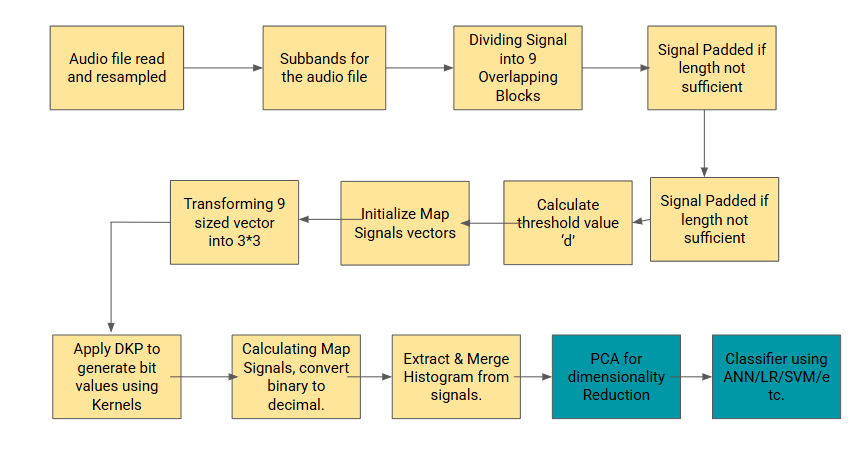

For generation of the CSV of features, 110 audio files of each label (1,2,3,4) were chosen randomly. This was done to ensure that the time required for processing of audio files is not very high, given the hardware constraints. The functions above were written as a python script wherein to apply on all the audio files.

### Working with the CSV generated for all the audio files

In [31]:
df = pd.read_csv(r'/content/audio_features_for_all_audios.csv')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Columns: 62977 entries, f0 to label
dtypes: int64(62977)
memory usage: 211.4 MB


In [33]:
df.iloc[:,-1]

,label
0,1
1,1
2,1
3,1
4,1
...,...
435,4
436,4
437,4
438,4


In [34]:
df.iloc[:,-1].unique()

array([1, 2, 3, 4])

In [35]:
#Checking for NaN values (explained below)
print(df.isnull().sum())

f0        0
f1        0
f2        0
f3        0
f4        0
         ..
f62972    0
f62973    0
f62974    0
f62975    0
label     0
Length: 62977, dtype: int64


In [36]:
df = df.dropna()
print(f"Original shape: {df.shape}")

Original shape: (440, 62977)


In [37]:
print((df['label'] == 1).sum())
print((df['label'] == 2).sum())
print((df['label'] == 3).sum())
print((df['label'] == 4).sum())

110
110
110
110


### Train-Test Split for the dataset

In [38]:
X = df.drop('label', axis=1)
y = df['label']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Performing PCA on the features obtained for dimensionality reduction.

The paper used INCA, an advanced feature selection technique based on the original Neighborhood Component Analysis (NCA) algorithm, which is designed for supervised dimensionality reduction and feature selection to improve classification performance. However for easier implementation, I used PCA for dimensionality reduction of the features.

Instead of choosing the number of lower dimensions, we have used amount of variance that should be retained (in this case 95%). Based on this, automatically the right number of components would be chosen.

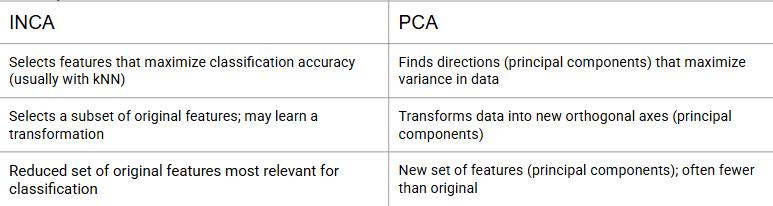

In [41]:
pca = PCA(n_components=0.95)

In [42]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### Defining Performance Metrics:

Macro F1 Score would be used to compare model performance.

*  Equal samples (110 per class), so macro-averaging won't be biased.

*  Multiclass setup: F1 balances precision and recall, making it more informative than raw accuracy if your model misclassifies certain classes disproportionately.

*  Scalable: It reflects how your model is doing across all classes, not just the most common one.

## Using Logistic Regression as a baseline.

Although Logistic Regression is a binary classifier, here we have used multinomial classification

In [102]:
model_LR = LogisticRegression(multi_class='multinomial')
model_LR.fit(X_train_pca, y_train)

LogisticRegression(multi_class='multinomial')

In [103]:
y_pred = model_LR.predict(X_test_pca)

In [104]:
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", macro_f1)

Macro F1 Score: 0.48544738885756533


### Random Forest

In [49]:
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [50]:
y_pred = rf_model.predict(X_test_pca)

In [52]:
print("Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))

Macro F1 Score: 0.43440670188148683


### Support Vector Classifier

In [53]:
from sklearn.svm import SVC

In [54]:
svc_model = SVC(kernel='rbf', random_state=42)
svc_model.fit(X_train_pca, y_train)

SVC(random_state=42)

In [55]:
y_pred = svc_model.predict(X_test_pca)
print("SVC Macro F1 Score:", f1_score(y_test, y_pred, average='macro'))

SVC Macro F1 Score: 0.41554383116883115


### Using custom ANN to gauge performace

#### Using Tensorflow and Keras to code a custom ANN, to compare the performance against the pre-trained models. We will set the Logistic Regression as baseline.

In [72]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score

In [73]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_cat = to_categorical(y_train_enc, num_classes=4)
y_test_cat = to_categorical(y_test_enc, num_classes=4)

In [74]:
model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dropout(0.2),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(512,activation = 'tanh'),
    Dropout(0.4),
    Dense(512,activation = 'tanh'),
    Dropout(0.1),
    Dense(512,activation = 'relu'),
    Dropout(0.1),
    Dense(256,activation = 'relu'),
    Dropout(0.1),
    Dense(256,activation = 'relu'),
    Dropout(0.1),
    Dense(128,activation = 'relu'),
    Dropout(0.1),
    Dense(64,activation = 'tanh'),
    Dropout(0.1),
    Dense(32,activation = 'relu'),
    Dropout(0.1),
    Dense(8,activation = 'relu'),
    Dense(4, activation='softmax')  # 4 output classes
])

In [75]:
optimizer = Adam(learning_rate=0.0001)

In [76]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
model.fit(X_train_pca, y_train_cat, epochs=400, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.2461 - loss: 1.4224 - val_accuracy: 0.3099 - val_loss: 1.3615
Epoch 2/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2489 - loss: 1.3952 - val_accuracy: 0.3944 - val_loss: 1.3511
Epoch 3/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2871 - loss: 1.3884 - val_accuracy: 0.4366 - val_loss: 1.3337
Epoch 4/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.2907 - loss: 1.3784 - val_accuracy: 0.4085 - val_loss: 1.2844
Epoch 5/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.3691 - loss: 1.3419 - val_accuracy: 0.4507 - val_loss: 1.2419
Epoch 6/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3626 - loss: 1.3334 - val_accuracy: 0.4930 - val_loss: 1.1993
Epoch 7/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4443 - loss: 1.2654 - val_accuracy: 0.4648 - val_loss: 1.1735
Epoch 8/400
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4468 - loss: 1.2213 - val_accuracy: 0.

In [78]:
y_pred_probs = model.predict(X_test_pca)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [79]:
loss, accuracy = model.evaluate(X_test_pca, y_test_cat, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f"Class {i+1}" for i in range(4)]))

macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"\nMacro F1 Score: {macro_f1:.4f}")

Test Accuracy: 0.5795

 Classification Report:
              precision    recall  f1-score   support

     Class 1       0.97      1.00      0.98        30
     Class 2       0.00      0.00      0.00        19
     Class 3       1.00      0.15      0.26        20
     Class 4       0.33      0.95      0.49        19

    accuracy                           0.58        88
   macro avg       0.58      0.52      0.43        88
weighted avg       0.63      0.58      0.50        88


Macro F1 Score: 0.4344


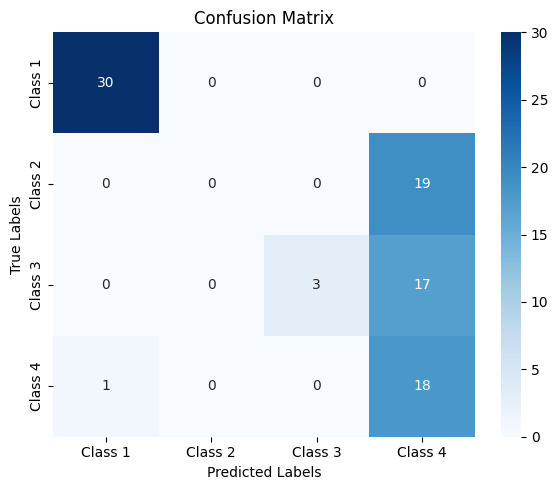

In [80]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i+1}" for i in range(4)],
            yticklabels=[f"Class {i+1}" for i in range(4)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

Confusion Matrix can be used to gauge classwise predictions.

Rows = Actual/True labels (Class 1 to Class 4)

Columns = Predicted labels

In [105]:
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.5)
    dropout2 = trial.suggest_float('dropout2', 0.1, 0.5)
    dropout3 = trial.suggest_float('dropout3', 0.1, 0.5)

    model = Sequential([
        Dense(1024, activation='relu', input_shape=(X_train_pca.shape[1],)),
        Dropout(dropout1),
        Dense(1024, activation='relu'),
        Dropout(dropout2),
        Dense(512, activation='tanh'),
        Dropout(dropout3),
        Dense(512, activation='tanh'),
        Dropout(0.1),
        Dense(512, activation='relu'),
        Dropout(0.1),
        Dense(256, activation='relu'),
        Dropout(0.1),
        Dense(256, activation='relu'),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='tanh'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dense(4, activation='softmax')
    ])

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_pca, y_train_cat,
              epochs=50,  # You can increase if needed
              batch_size=16,
              validation_split=0.2,
              verbose=0)

    # Predict on the validation portion of training set
    val_size = int(0.2 * len(X_train_pca))
    X_val = X_train_pca[-val_size:]
    y_val = y_train_cat[-val_size:]

    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_true = np.argmax(y_val, axis=1)

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return macro_f1

In [107]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-05-09 10:27:20,011] A new study created in memory with name: no-name-9170c486-8aff-410c-9b6c-f26ddc5aa602


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-09 10:28:15,536] Trial 0 finished with value: 0.34807692307692306 and parameters: {'lr': 2.8485161069294196e-05, 'dropout1': 0.3193815851981844, 'dropout2': 0.41086220677849494, 'dropout3': 0.47617738104651686}. Best is trial 0 with value: 0.34807692307692306.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


[I 2025-05-09 10:29:15,644] Trial 1 finished with value: 0.4570767195767196 and parameters: {'lr': 5.903814343655067e-05, 'dropout1': 0.363713408892713, 'dropout2': 0.36781670794759236, 'dropout3': 0.3895179953461423}. Best is trial 1 with value: 0.4570767195767196.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


[I 2025-05-09 10:30:11,786] Trial 2 finished with value: 0.47989766081871343 and parameters: {'lr': 0.0008393611333994068, 'dropout1': 0.30033176580865495, 'dropout2': 0.49720232843653067, 'dropout3': 0.3796354608731558}. Best is trial 2 with value: 0.47989766081871343.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


[I 2025-05-09 10:31:08,462] Trial 3 finished with value: 0.43210354317165467 and parameters: {'lr': 0.00040483184886833443, 'dropout1': 0.21264568358885227, 'dropout2': 0.15351690849768662, 'dropout3': 0.4746505331974721}. Best is trial 2 with value: 0.47989766081871343.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


[I 2025-05-09 10:32:04,528] Trial 4 finished with value: 0.41954365079365075 and parameters: {'lr': 0.0009800252353447851, 'dropout1': 0.1451207976853997, 'dropout2': 0.48121255780828875, 'dropout3': 0.3562251413020897}. Best is trial 2 with value: 0.47989766081871343.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


[I 2025-05-09 10:32:58,580] Trial 5 finished with value: 0.3932379969531672 and parameters: {'lr': 0.00021697255121152468, 'dropout1': 0.3278485328930123, 'dropout2': 0.19605514336263907, 'dropout3': 0.20424953080639133}. Best is trial 2 with value: 0.47989766081871343.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


[I 2025-05-09 10:33:53,794] Trial 6 finished with value: 0.37141319942611195 and parameters: {'lr': 1.5760307710091604e-05, 'dropout1': 0.18938013258885814, 'dropout2': 0.3610086564453604, 'dropout3': 0.28111734703473135}. Best is trial 2 with value: 0.47989766081871343.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


[I 2025-05-09 10:34:51,761] Trial 7 finished with value: 0.4076008781891135 and parameters: {'lr': 0.0003405800945320091, 'dropout1': 0.23965336769344614, 'dropout2': 0.40361398160901907, 'dropout3': 0.21999998191701256}. Best is trial 2 with value: 0.47989766081871343.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


[I 2025-05-09 10:35:47,958] Trial 8 finished with value: 0.43022737022737023 and parameters: {'lr': 5.8852050091189285e-05, 'dropout1': 0.2080355287363319, 'dropout2': 0.33115595954641863, 'dropout3': 0.44286474972022627}. Best is trial 2 with value: 0.47989766081871343.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


[I 2025-05-09 10:36:42,563] Trial 9 finished with value: 0.34807692307692306 and parameters: {'lr': 3.303475946046504e-05, 'dropout1': 0.357437610680747, 'dropout2': 0.23032127880888462, 'dropout3': 0.41863589240348675}. Best is trial 2 with value: 0.47989766081871343.


In [108]:
print("Best trial:")
trial = study.best_trial

print(f"  Macro F1 Score: {trial.value}")
print("  Best Hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Macro F1 Score: 0.47989766081871343
  Best Hyperparameters:
    lr: 0.0008393611333994068
    dropout1: 0.30033176580865495
    dropout2: 0.49720232843653067
    dropout3: 0.3796354608731558


### Results & Conclusion:

Macro F1 Scores for all the models used:

*  ANN: 0.4344
*  SVC: 0.4155
*  Random Forest = 0.4344
*  Multinomial Logistic Regression: 0.4855

### References & Tools:

1) Kuluozturk M, Kobat MA, Barua PD, Dogan S, Tuncer T, Tan RS, Ciaccio EJ, Acharya UR. DKPNet41: Directed knight pattern network-based cough sound classification model for automatic disease diagnosis. Med Eng Phys. 2022 Dec;110:103870. doi: 10.1016/j.medengphy.2022.103870. Epub 2022 Aug 6. PMID: 35989223; PMCID: PMC9356574.

2) perplexity.ai

3) notebooklm.google.com
